In [1]:
# General imports
#import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import MeanSquaredError, MeanSquaredLogarithmicError
from tensorflow.keras.optimizers import Adam

import pydot
import os
from pathlib import Path

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import mean_squared_log_error, mean_squared_error
#import xgboost as xgb
                
# Project imports
from utils.images_loader import ImagesLoader
from utils.text_data_loader import TextDataLoader
from utils.utilities import plot_history
from utils.utilities import rmsle
from model import TextOnlyModel, ImageAndTextModel
from train import load_x_y_from_loaders
from train import IMAGE_INPUT_NAME, TEXT_FEATURES_INPUT_NAME, OUTPUT_NAME



In [2]:
# Params
use_scaling = True
include_images = True

# data paths
train_text_path = r'./src_data/train.csv'
train_images_folder = r'./src_data/train_profile_images'
test_text_path = r'./src_data/test.csv'
test_images_folder = r'./src_data/test_profile_images'
log_folder = 'logs'

In [3]:
# TRAIN
# Images loader
print('\nTRAIN:')
images_loader = ImagesLoader(src_folder_path = train_images_folder)
print('Number images: {:}'.format(images_loader.nbr_images))
print('Images shape: {:}'.format(images_loader.image_shape))
# Text data loader
text_data_loader = TextDataLoader(src_csv_file_path = train_text_path)

# TEST
# Test Images loader
print('\nTEST:')
test_images_loader = ImagesLoader(src_folder_path = test_images_folder)
print('Number images: {:}'.format(test_images_loader.nbr_images))
print('Images shape: {:}'.format(test_images_loader.image_shape))
# Test Text data loader
test_text_data_loader = TextDataLoader(src_csv_file_path = test_text_path)


# Get and profile by its ID
profile_id = '00NJOGS399G79OP3'
image_data = images_loader.get_image_data_for_profile_id(profile_id)
text_data = text_data_loader.get_orig_data_for_profile_id(profile_id)




TRAIN:
Number images: 7500
Images shape: (32, 32, 3)

TEST:
Number images: 2500
Images shape: (32, 32, 3)


In [4]:
# Print data for this profile
#print(text_data)

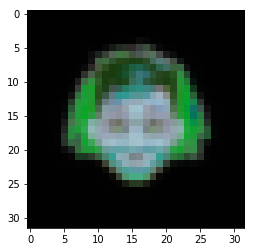

In [5]:
# Show profile image
plt.imshow(image_data)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CD6F637668>]],
      dtype=object)

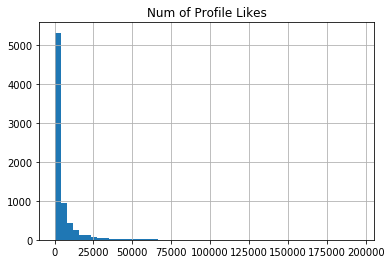

In [6]:
features = text_data_loader.get_transformed_features()
#features = data.drop(columns =['Id', 'Num of Profile Likes'])
features.hist(column='Num of Profile Likes', log=False, bins=50)


    

In [7]:
features['Num of Profile Likes'].min()+1

1

In [8]:
pt_cox = PowerTransformer(method='box-cox', standardize=False)

features['Num of Profile Likes box-cox'] = features['Num of Profile Likes'] + 1 
features['Num of Profile Likes box-cox'] = pt_cox.fit_transform(features['Num of Profile Likes box-cox'].values.reshape(-1, 1))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CD72805550>]],
      dtype=object)

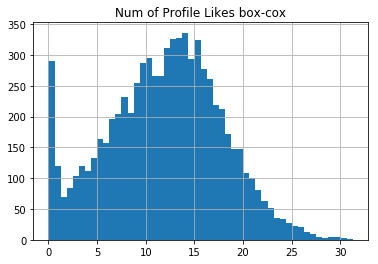

In [9]:
features.hist(column='Num of Profile Likes box-cox', log=False, bins=50)

In [10]:
features['Num of Profile Likes box-cox reverse'] = (pt_cox.inverse_transform(features['Num of Profile Likes box-cox'].values.reshape(-1, 1))-1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CD728EA7B8>]],
      dtype=object)

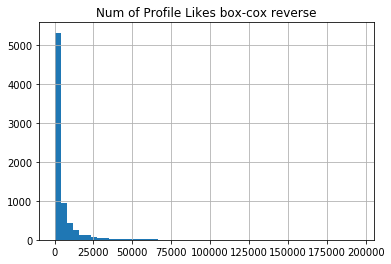

In [11]:
features.hist(column='Num of Profile Likes box-cox reverse', log=False, bins=50)

In [12]:
#features[['Num of Profile Likes box-cox reverse', 'Num of Profile Likes']]

In [13]:
# -- Split ids to train/valid --
all_profiles_ids_list = text_data_loader.get_transformed_features()['Id'].values

train_profiles_ids, valid_profiles_ids = train_test_split(all_profiles_ids_list, test_size = .2, random_state=42, shuffle=True)

In [14]:
#-- Preare data for model  Train/Valid--
# Will use a dict to associate the corresponding data to the right input in the model (Image vs Features)

# TODO DEBUG using scaling for tests
if use_scaling:
    #sc_x = StandardScaler()
    sc_x = PowerTransformer(method='box-cox', standardize=True) #StandardScaler()
    pt_cox_y = PowerTransformer(method='box-cox', standardize=True) #StandardScaler()

# - Train: use train_profiles_ids
train_X, train_y = load_x_y_from_loaders(images_loader=images_loader,
                                        text_data_loader=text_data_loader,
                                        profiles_ids_list=train_profiles_ids,
                                        include_images=include_images)
if use_scaling:
    # Fit and Transform on Train
    train_X[TEXT_FEATURES_INPUT_NAME] = sc_x.fit_transform(train_X[TEXT_FEATURES_INPUT_NAME] + 1)
    train_y[OUTPUT_NAME] = pt_cox_y.fit_transform((train_y[OUTPUT_NAME] + 1).reshape(-1, 1))

# - Valid: use valid_profiles_ids
valid_X, valid_y = load_x_y_from_loaders(images_loader=images_loader,
                             text_data_loader=text_data_loader,
                             profiles_ids_list=valid_profiles_ids,
                             include_images=include_images)

if use_scaling:
    # Transform only on Valid
    valid_X[TEXT_FEATURES_INPUT_NAME] = sc_x.transform(valid_X[TEXT_FEATURES_INPUT_NAME] + 1)
    valid_y[OUTPUT_NAME] = pt_cox_y.transform((valid_y[OUTPUT_NAME] + 1).reshape(-1, 1))


In [15]:
valid_y

{'likes': array([[ 0.40387238],
        [ 0.01448984],
        [-0.94185181],
        ...,
        [ 1.42023026],
        [ 0.68554207],
        [-0.47824502]])}

In [16]:
valid_y[OUTPUT_NAME]

array([[ 0.40387238],
       [ 0.01448984],
       [-0.94185181],
       ...,
       [ 1.42023026],
       [ 0.68554207],
       [-0.47824502]])

In [17]:
train_y[OUTPUT_NAME]

array([[ 0.01593418],
       [ 0.1193539 ],
       [ 0.83475002],
       ...,
       [ 0.07228083],
       [ 0.01340395],
       [-0.03598814]])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CD72A09860>]],
      dtype=object)

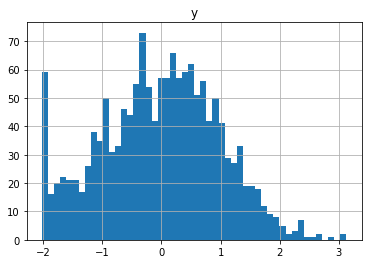

In [18]:
y_df = pd.DataFrame(data=valid_y[OUTPUT_NAME],
                    columns=['y'])
y_df.describe()
y_df.hist(column='y', log=False, bins=50)

In [19]:
orig_columns_names = text_data_loader.get_transformed_features().drop(columns =['Id', 'Num of Profile Likes']).columns.values
columns_nbr = np.array(np.arange(train_X[TEXT_FEATURES_INPUT_NAME].shape[1]))
col_dict = dict(zip(columns_nbr, orig_columns_names))#[{col_nbr: col_name} for col_nbr, col_name in zip(columns_nbr, orig_columns_names)]
df = pd.DataFrame(data=train_X[TEXT_FEATURES_INPUT_NAME],    # values
                  columns=columns_nbr)

In [20]:
col_dict

{0: 'Profile Cover Image Status',
 1: 'Is Profile View Size Customized?',
 2: 'Location Public Visibility',
 3: 'Num of Followers',
 4: 'Num of People Following',
 5: 'Num of Status Updates',
 6: 'Num of Direct Messages',
 7: 'Avg Daily Profile Visit Duration in seconds',
 8: 'Avg Daily Profile Clicks',
 9: 'Profile Text Color_r',
 10: 'Profile Text Color_g',
 11: 'Profile Text Color_b',
 12: 'Profile Page Color_r',
 13: 'Profile Page Color_g',
 14: 'Profile Page Color_b',
 15: 'Profile Theme Color_r',
 16: 'Profile Theme Color_g',
 17: 'Profile Theme Color_b',
 18: 'Has Personal URL',
 19: 'Account Age Days',
 20: 'Verification_Status_Not verified',
 21: 'Verification_Status_Pending',
 22: 'Verification_Status_Verified',
 23: 'Category_business',
 24: 'Category_celebrity',
 25: 'Category_government',
 26: 'Category_unknown',
 27: 'Language_ar',
 28: 'Language_de',
 29: 'Language_en',
 30: 'Language_es',
 31: 'Language_fr',
 32: 'Language_it',
 33: 'Language_ja',
 34: 'Language_other',

In [21]:
df.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
4330,-1.788972,-0.324802,-1.181796,0.255111,0.504583,1.274377,0.049408,0.404411,-0.235269,-1.068713,...,-0.08299,-0.111803,0.626366,-0.363922,-0.174436,-0.124852,-0.134174,-0.170332,-0.186271,-0.147718
3122,0.558980,-0.324802,-1.181796,0.301279,-0.362812,0.409269,0.918999,-0.666605,-0.436292,-1.068713,...,-0.08299,-0.111803,-1.596510,-0.363922,-0.174436,-0.124852,-0.134174,-0.170332,5.368510,-0.147718
1739,0.558980,-0.324802,0.846170,0.020300,0.775461,-0.131646,0.818239,0.269332,0.497552,-1.068713,...,-0.08299,-0.111803,0.626366,-0.363922,-0.174436,-0.124852,-0.134174,-0.170332,-0.186271,-0.147718
506,0.558980,-0.324802,-1.181796,-1.879865,0.325500,-0.679062,-1.476657,0.408840,-0.096966,-0.756947,...,-0.08299,-0.111803,0.626366,-0.363922,-0.174436,-0.124852,-0.134174,-0.170332,-0.186271,-0.147718
3239,0.558980,-0.324802,0.846170,0.386625,-0.501101,-1.065903,-0.046069,-1.388357,-0.481648,-0.058005,...,-0.08299,-0.111803,0.626366,-0.363922,-0.174436,-0.124852,-0.134174,-0.170332,-0.186271,-0.147718


Account Age Days
count    5.994000e+03
mean     2.951704e-16
std      1.000083e+00
min     -2.331809e+00
25%     -7.532789e-01
50%      1.553913e-01
75%      7.427894e-01
max      3.118591e+00
Name: 19, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CD72A05A58>]],
      dtype=object)

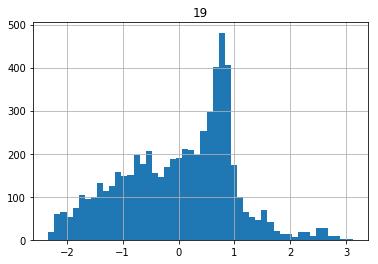

In [22]:
feature_idx = 19
print(col_dict[feature_idx])
print(df[feature_idx].describe())
df.hist(column=feature_idx, log=False, bins=50)

Num of People Following
count    5.994000e+03
mean    -2.290831e-16
std      1.000083e+00
min     -2.998828e+00
25%     -5.408326e-01
50%      2.418450e-02
75%      5.406778e-01
max      3.519089e+00
Name: 4, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CD7B8B5EB8>]],
      dtype=object)

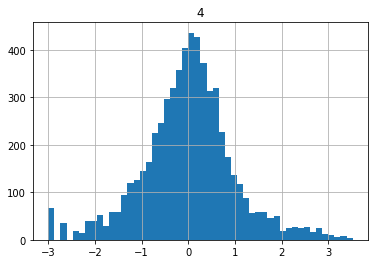

In [23]:
feature_idx = 4
print(col_dict[feature_idx])
print(df[feature_idx].describe())
df.hist(column=feature_idx, log=False, bins=50)

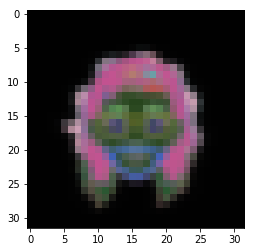

In [24]:
idx = 10

#vX, valid_X
#vy, valid_y
plt.imshow(train_X[IMAGE_INPUT_NAME][idx])
plt.show()

In [25]:
# -- Preare data for model  All DATA and TEST --

all_data_profiles_ids_list = text_data_loader.get_transformed_features()['Id'].values
all_test_profiles_ids_list = test_text_data_loader.get_transformed_features()['Id'].values


# TODO DEBUG using scaling for tests
if use_scaling:
    sc_alldata_x = StandardScaler()
    sc_alldata_y = PowerTransformer(method='box-cox', standardize=False) #StandardScaler()

#- All Train data
data_X, data_y = load_x_y_from_loaders(images_loader=images_loader,
                             text_data_loader=text_data_loader,
                             profiles_ids_list=all_data_profiles_ids_list,
                             include_images=True)
if use_scaling:
    # Fit and Transform on Train
    data_X[TEXT_FEATURES_INPUT_NAME] = sc_alldata_x.fit_transform(data_X[TEXT_FEATURES_INPUT_NAME])
    data_y[OUTPUT_NAME] = sc_alldata_y.fit_transform((data_y[OUTPUT_NAME] + 1).reshape(-1, 1))


#- Test data
test_X = load_x_y_from_loaders(images_loader=test_images_loader,
                             text_data_loader=test_text_data_loader,
                             profiles_ids_list=all_test_profiles_ids_list,
                             include_images=True)
if use_scaling:
    # Transform only on Test
    test_X[TEXT_FEATURES_INPUT_NAME] = sc_alldata_x.fit_transform(test_X[TEXT_FEATURES_INPUT_NAME])

In [26]:
all_test_profiles_ids_list

array(['49I3SOKLI2CMNGP4', '727IRIR59A3P88LK', 'LN95SD15SRPCEE8F', ...,
       'SRNIBIK27BQ2M3PB', '6CP232J9R8N84702', 'AROR24MH3M79EHBS'],
      dtype=object)

(32, 32, 3)
[0.01593418]
(32, 32, 3)


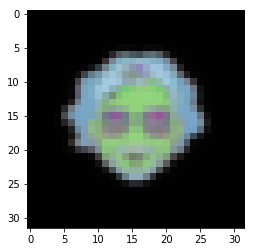

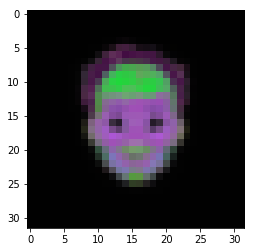

In [27]:
idx = 0
print(train_X[IMAGE_INPUT_NAME][idx].shape)
print(train_y[OUTPUT_NAME][idx])
print(test_X[IMAGE_INPUT_NAME][idx].shape)

plt.imshow(train_X[IMAGE_INPUT_NAME][idx])
plt.show()

plt.imshow(test_X[IMAGE_INPUT_NAME][idx])
plt.show()


In [30]:
# Keras models


# Need to reload model.py in case of changes
import imp
import model
imp.reload(model)
from model import TextOnlyModel, ImageAndTextModel

# GPU specific
os.environ['CUDA_VISIBLE_DEVICES']='1'
# Hyper-params TODO move to json file? for better modularity and tracking
learning_rate = 0.001
training_batch_size = 32 #32
n_epochs = 50



# -- Prepare model --
image_height = images_loader.image_shape[0]
image_width = images_loader.image_shape[1]
image_nbr_channels = images_loader.image_shape[2]
nbr_text_features = train_X[TEXT_FEATURES_INPUT_NAME].shape[1] # TODO text_data_loader.get_nbr_features()


# Text and Image model
if include_images:
    model = ImageAndTextModel(image_height = image_height,
                            image_width = image_width,
                            image_nbr_channels = image_nbr_channels,
                            nbr_text_features = nbr_text_features,
                            image_input_name=IMAGE_INPUT_NAME,
                            text_features_input_name=TEXT_FEATURES_INPUT_NAME,
                            output_name=OUTPUT_NAME)

# Text only model
else :
    model = TextOnlyModel(nbr_text_features = nbr_text_features,
                            text_features_input_name=TEXT_FEATURES_INPUT_NAME,
                            output_name=OUTPUT_NAME)

# Model summary
model.summary() # TODO model summary to file
plot_model(model, os.path.join(log_folder, 'model.png'), show_shapes=True)

# -- Compile model --
model.compile(loss=MeanSquaredLogarithmicError(), #MeanSquaredError(),
                optimizer=Adam(lr=learning_rate),
                metrics=['mean_squared_logarithmic_error', 'mean_squared_error'])


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
text_features (InputLayer)      [(None, 37)]         0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 8)    224         image[0][0]                      
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 37)           1406        text_features[0][0]              
____________________________________________________________________________________________

In [31]:
# -- Fit model --
hist = model.fit(x=train_X,
                    y=train_y,
                    batch_size = training_batch_size,
                    validation_data=(valid_X, valid_y),
                    epochs=n_epochs,
                    verbose=1)

Train on 5994 samples, validate on 1499 samples
Epoch 1/50
5994/5994 [==============================] - 6s 1ms/sample - loss: 0.1339 - mean_squared_logarithmic_error: 0.1339 - mean_squared_error: 1.0797 - val_loss: 0.0935 - val_mean_squared_logarithmic_error: 0.0935 - val_mean_squared_error: 0.9649
Epoch 2/50
5994/5994 [==============================] - 2s 392us/sample - loss: 0.1010 - mean_squared_logarithmic_error: 0.1010 - mean_squared_error: 0.9746 - val_loss: 0.0847 - val_mean_squared_logarithmic_error: 0.0847 - val_mean_squared_error: 0.9343
Epoch 3/50
5994/5994 [==============================] - 2s 385us/sample - loss: 0.0948 - mean_squared_logarithmic_error: 0.0948 - mean_squared_error: 0.9353 - val_loss: 0.0821 - val_mean_squared_logarithmic_error: 0.0821 - val_mean_squared_error: 0.8949
Epoch 4/50
5994/5994 [==============================] - 2s 385us/sample - loss: 0.0891 - mean_squared_logarithmic_error: 0.0891 - mean_squared_error: 0.8677 - val_loss: 0.0771 - val_mean_squar

Epoch 33/50
5994/5994 [==============================] - 2s 388us/sample - loss: 0.0691 - mean_squared_logarithmic_error: 0.0691 - mean_squared_error: 0.9016 - val_loss: 0.0683 - val_mean_squared_logarithmic_error: 0.0683 - val_mean_squared_error: 0.5672
Epoch 34/50
5994/5994 [==============================] - 2s 390us/sample - loss: 0.0701 - mean_squared_logarithmic_error: 0.0701 - mean_squared_error: 0.8528 - val_loss: 0.0678 - val_mean_squared_logarithmic_error: 0.0678 - val_mean_squared_error: 0.5671
Epoch 35/50
5994/5994 [==============================] - 2s 386us/sample - loss: 0.0692 - mean_squared_logarithmic_error: 0.0692 - mean_squared_error: 0.7522 - val_loss: 0.0696 - val_mean_squared_logarithmic_error: 0.0696 - val_mean_squared_error: 0.5638
Epoch 36/50
5994/5994 [==============================] - 2s 388us/sample - loss: 0.0701 - mean_squared_logarithmic_error: 0.0701 - mean_squared_error: 0.7377 - val_loss: 0.0689 - val_mean_squared_logarithmic_error: 0.0689 - val_mean_sq

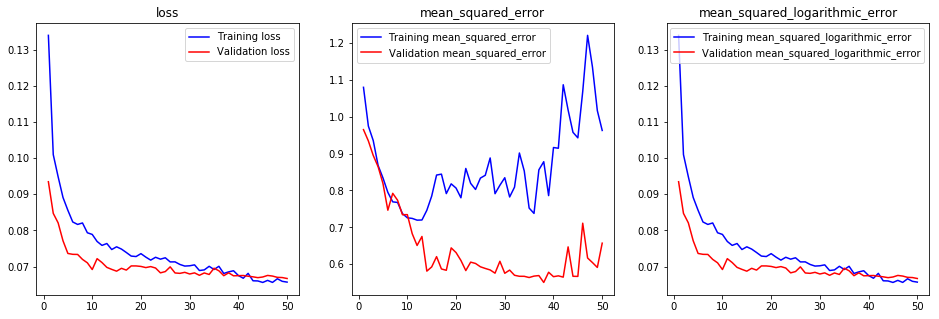

In [32]:
plot_history(hist)

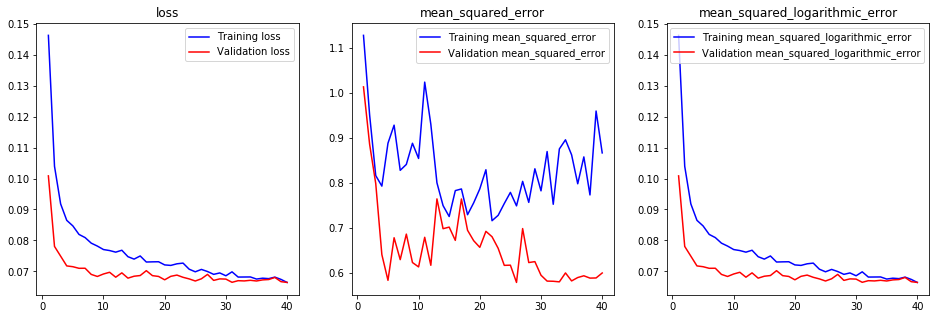

In [75]:
plot_history(hist)

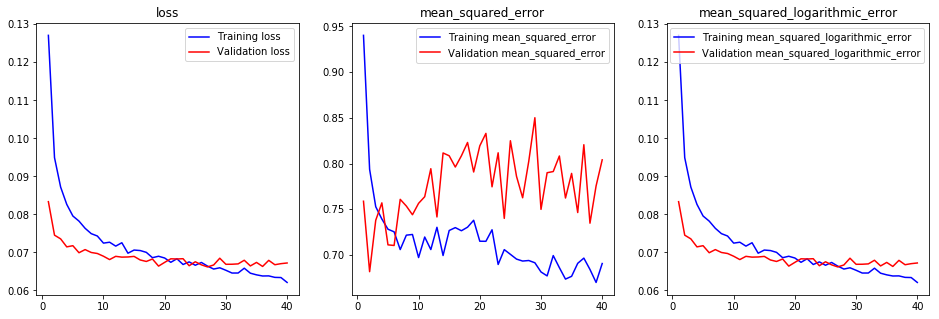

In [70]:
plot_history(hist)

In [33]:
# Evaluation
valid_pred_y = model.predict(valid_X)

# Scale predicted values back
scaled_valid_y = pt_cox_y.inverse_transform(valid_y[OUTPUT_NAME] - 1).astype(int)
scaled_valid_pred_y = pt_cox_y.inverse_transform(valid_pred_y - 1).astype(int)

# Make sure predicted and scaled back values are not negatives!
idexes = np.nonzero(scaled_valid_pred_y < 0)
scaled_valid_pred_y[idexes] = 0

# Compute rmse and rmsle
rmse_val = np.sqrt(mean_squared_error(scaled_valid_pred_y, scaled_valid_y))
print('sqrt mse: {:}'.format(rmse_val))
rmsle_val = rmsle(scaled_valid_pred_y, scaled_valid_y)
print('rmsle: {:}'.format(rmsle_val))

sqrt mse: 2729.979943576183
rmsle: 2.068802625291884


In [78]:
# Prepare data for non NN models

train_values_X= train_X[TEXT_FEATURES_INPUT_NAME]
train_values_y= train_y[OUTPUT_NAME]

valid_values_X= valid_X[TEXT_FEATURES_INPUT_NAME]
valid_values_y= valid_y[OUTPUT_NAME]

print('Train shape {:}'.format(train_values_X.shape, train_values_y.shape))
print('Valid shape {:}'.format(valid_values_X.shape, valid_values_y.shape))

Train shape (5994, 37)
Valid shape (1499, 37)


In [79]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor


reg_forest = RandomForestRegressor(#n_estimators=500,
                                   random_state=42,
                                   verbose=1)

reg_forest.fit(train_values_X, train_values_y)

valid_pred_y = reg_forest.predict(valid_values_X)

c:\users\aelimame\.conda\envs\ift6758\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\aelimame\.conda\envs\ift6758\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [80]:
# Evaluation

# Scale predicted values back
scaled_valid_y = pt_cox_y.inverse_transform(valid_values_y.reshape(-1,1) - 1).astype(int)
scaled_valid_pred_y = pt_cox_y.inverse_transform(valid_pred_y.reshape(-1,1) - 1).astype(int)

# Make sure predicted and scaled back values are not negatives!
idexes = np.nonzero(scaled_valid_pred_y < 0)
scaled_valid_pred_y[idexes] = 0

# Compute rmse and rmsle
rmse_val = np.sqrt(mean_squared_error(scaled_valid_pred_y, scaled_valid_y))
print('sqrt mse: {:}'.format(rmse_val))
rmsle_val = rmsle(scaled_valid_pred_y, scaled_valid_y)
print('rmsle: {:}'.format(rmsle_val))

sqrt mse: 2627.4000049206893
rmsle: 1.9941083433374973


In [81]:
scaled_valid_y

array([[ 273],
       [  86],
       [   1],
       ...,
       [2909],
       [ 571],
       [  14]])

In [82]:
scaled_valid_pred_y

array([[2016],
       [ 125],
       [   3],
       ...,
       [1357],
       [ 468],
       [  22]])

In [ ]:
# -- Train on all data and predict on test set --
# RANDOM FOREST using Text features only
alldataset_X= data_X[TEXT_FEATURES_INPUT_NAME]
alldataset_y= data_y[OUTPUT_NAME]

testset_X= test_X[TEXT_FEATURES_INPUT_NAME]

print('Train shape {:}'.format(alldataset_X.shape, alldataset_y.shape))
print('Valid shape {:}'.format(testset_X.shape))

# Train Random Forest
from sklearn.ensemble import RandomForestRegressor
reg_forest = RandomForestRegressor(random_state=42,
                                   verbose=1)
reg_forest.fit(alldataset_X, alldataset_y)

# Predict on Test set
test_pred_y = reg_forest.predict(testset_X)

# Scale predicted values to int
scaled_test_pred_y = sc_alldata_y.inverse_transform(test_pred_y.reshape(-1,1)).astype(int)

# Make sure predicted and scaled back values are not negatives!
idexes = np.nonzero(scaled_test_pred_y < 0)
scaled_test_pred_y[idexes] = 0


In [ ]:
testset_X
#scaled_test_pred_y

In [ ]:
scaled_test_pred_y

In [ ]:
scaled_test_pred_y

In [ ]:
all_test_profiles_ids_list

In [ ]:
# Store in DataFrame and save predictions
test_pd = pd.DataFrame()
test_pd['Id'] = all_test_profiles_ids_list
test_pd['Predicted'] = scaled_test_pred_y

test_tosubmit_folder = os.path.join(log_folder,'v1-cox-box-on-likes')
# Create log folder if does not exist
if not Path(test_tosubmit_folder).exists():
    os.mkdir(test_tosubmit_folder)
test_name = 'RandomForestRegressor-randstate42-cox-box-on-likes-gitversion-xxxx-2020-11-27'
test_pd.to_csv(os.path.join(test_tosubmit_folder, test_name+'.csv'), sep=',', index=False)

In [ ]:
# Fit xgboost
if 0:
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                                max_depth=500,
                                n_estimators=100,
                                random_state=42)
    xgb_model.fit(tr_X, tr_y, eval_set=[(val_X, val_y)])

    val_pred_y = xgb_model.predict(val_X)


In [ ]:
scaled_valid_pred_y.shape

In [ ]:
scaled_valid_pred_y.min()